<a href="https://colab.research.google.com/github/saadzh05/1-re-ann-e-IA-OFPPT/blob/main/TP_01_Pyspark_Colab/SAAD_ZAHRANE/TP_PySpark_Suicide_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP PySpark — Analyse du Taux de Suicide Mondial (2024)

**Dataset :** `suicide-rate-by-country-2024.csv` — données OMS sur les taux de suicide par pays.

| Colonne | Description |
|---------|-------------|
| `country` | Nom du pays |
| `SuicideRate_BothSexes_RatePer100k_2021` | Taux global pour 100 000 habitants (2021) |
| `SuicideRate_Male_RatePer100k_2021` | Taux masculin pour 100 000 habitants (2021) |
| `SuicideRate_Female_RatePer100k_2021` | Taux féminin pour 100 000 habitants (2021) |
| *(mêmes colonnes pour 2020 et 2019)* | ... |

> Ce notebook est conçu pour fonctionner directement sur **Google Colab** sans aucune configuration supplémentaire.


## Partie 0 — Installation de PySpark

Apache Spark est écrit en Java. PySpark est l'interface Python. Sans Java → Spark ne fonctionne pas.
On installe PySpark via `pip` et on vérifie que Java est disponible.


In [1]:
# Installation de PySpark
!pip install pyspark -q

# Vérification de la version Java
!java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


## Partie 1 — Chargement du Dataset

On upload le fichier CSV depuis notre machine locale vers Colab.


In [2]:
# Upload du fichier CSV dans Colab
from google.colab import files
uploaded = files.upload()  # Sélectionner 'suicide-rate-by-country-2024.csv'

# Le fichier sera disponible dans le répertoire courant
import os
print("Fichiers disponibles :", os.listdir('.'))

Saving suicide-rate-by-country-2024.csv to suicide-rate-by-country-2024 (1).csv
Fichiers disponibles : ['.config', 'suicide-rate-by-country-2024.csv', 'suicide-rate-by-country-2024 (1).csv', 'sample_data']


## Partie 2 — SparkContext et RDD (Approche bas niveau)

Le **SparkContext** est le point d'entrée historique de Spark. Il permet de travailler avec des **RDD** (Resilient Distributed Datasets).

> Un RDD est une collection distribuée, immuable et tolérante aux pannes.

```
Mode local (Colab) :
local[*] → utilise tous les cœurs CPU disponibles
    ├── Thread 1 → Partition 1
    ├── Thread 2 → Partition 2
    └── Thread 3 → Partition 3
```


In [3]:
from pyspark import SparkContext, SparkConf

# Créer un SparkContext en mode local
conf = SparkConf().setAppName("SuicideRateAnalysis").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

print(f"SparkContext créé !")
print(f"Version Spark : {sc.version}")
print(f"Maître : {sc.master}")
print(f"Nom de l'app : {sc.appName}")

SparkContext créé !
Version Spark : 4.0.2
Maître : local[*]
Nom de l'app : SuicideRateAnalysis


### 2.1 — Lire le fichier avec un RDD

`sc.textFile()` lit chaque ligne comme une chaîne de caractères. On doit ensuite parser le CSV manuellement.


In [4]:
import csv, io

# Lire le fichier ligne par ligne
rdd_raw = sc.textFile("suicide-rate-by-country-2024.csv")

# Afficher les 3 premières lignes
print("Premières lignes brutes :")
for line in rdd_raw.take(3):
    print(line)

print(f"\nNombre total de lignes (avec entête) : {rdd_raw.count()}")

Premières lignes brutes :
"country","SuicideRate_BothSexes_RatePer100k_2021","SuicideRate_Male_RatePer100k_2021","SuicideRate_Female_RatePer100k_2021","SuicideRate_BothSexes_RatePer100k_2020","SuicideRate_Male_RatePer100k_2020","SuicideRate_Female_RatePer100k_2020","SuicideRate_BothSexes_RatePer100k_2019","SuicideRate_Male_RatePer100k_2019","SuicideRate_Female_RatePer100k_2019"
"India",13.33,15.7,10.85,13.28,15.7,10.73,12.7,14.1,11.1
"China",9.17,10.64,7.63,9.04,10.52,7.5,8.1,9.8,6.2

Nombre total de lignes (avec entête) : 205


In [5]:
# Extraire l'entête
header = rdd_raw.first()
print("Colonnes :", header)

# Filtrer l'entête et parser le CSV
def parse_line(line):
    reader = csv.reader(io.StringIO(line))
    return next(reader)

rdd_data = rdd_raw.filter(lambda line: line != header) \
                  .map(parse_line)

print(f"\nNombre de pays : {rdd_data.count()}")
print("\nExemple de ligne parsée :")
print(rdd_data.first())

Colonnes : "country","SuicideRate_BothSexes_RatePer100k_2021","SuicideRate_Male_RatePer100k_2021","SuicideRate_Female_RatePer100k_2021","SuicideRate_BothSexes_RatePer100k_2020","SuicideRate_Male_RatePer100k_2020","SuicideRate_Female_RatePer100k_2020","SuicideRate_BothSexes_RatePer100k_2019","SuicideRate_Male_RatePer100k_2019","SuicideRate_Female_RatePer100k_2019"

Nombre de pays : 204

Exemple de ligne parsée :
['India', '13.33', '15.7', '10.85', '13.28', '15.7', '10.73', '12.7', '14.1', '11.1']


### 2.2 — Transformations RDD : extraire les taux de suicide 2021

On applique les transformations classiques MapReduce :
- `map()` → transformer chaque élément
- `filter()` → garder les éléments valides
- `sortBy()` → trier


In [6]:
# Extraire (pays, taux_global_2021)
def extract_country_rate(fields):
    try:
        country = fields[0].strip('"')
        rate = float(fields[1])  # BothSexes 2021
        return (country, rate)
    except:
        return None

rdd_rates = rdd_data.map(extract_country_rate) \
                    .filter(lambda x: x is not None)

print(f"Pays avec données valides : {rdd_rates.count()}")
print("\nExemples :")
for c, r in rdd_rates.take(5):
    print(f"  {c:<30} → {r:.2f} pour 100 000 hab")

Pays avec données valides : 204

Exemples :
  India                          → 13.33 pour 100 000 hab
  China                          → 9.17 pour 100 000 hab
  United States                  → 15.25 pour 100 000 hab
  Indonesia                      → 1.64 pour 100 000 hab
  Pakistan                       → 5.82 pour 100 000 hab


In [7]:
# TOP 10 pays avec les taux les plus élevés (2021)
top10_highest = rdd_rates.sortBy(lambda x: x[1], ascending=False).take(10)

print("TOP 10 — Taux de suicide les plus ÉLEVÉS (2021)")
print("-" * 50)
for i, (country, rate) in enumerate(top10_highest, 1):
    bar = '█' * int(rate / 2)
    print(f"{i:2}. {country:<30} {rate:5.2f} {bar}")

TOP 10 — Taux de suicide les plus ÉLEVÉS (2021)
--------------------------------------------------
 1. Greenland                      59.62 █████████████████████████████
 2. Guyana                         31.26 ███████████████
 3. Lithuania                      27.91 █████████████
 4. South Korea                    25.81 ████████████
 5. Russia                         24.10 ████████████
 6. Suriname                       23.60 ███████████
 7. Nauru                          23.55 ███████████
 8. Ukraine                        23.17 ███████████
 9. Uruguay                        21.31 ██████████
10. Lesotho                        20.57 ██████████


In [8]:
# TOP 10 pays avec les taux les plus FAIBLES (2021)
top10_lowest = rdd_rates.sortBy(lambda x: x[1], ascending=True).take(10)

print("TOP 10 — Taux de suicide les plus FAIBLES (2021)")
print("-" * 50)
for i, (country, rate) in enumerate(top10_lowest, 1):
    print(f"{i:2}. {country:<30} {rate:5.2f}")

TOP 10 — Taux de suicide les plus FAIBLES (2021)
--------------------------------------------------
 1. Palestine                       0.78
 2. Syria                           0.89
 3. Lebanon                         0.94
 4. Egypt                           1.01
 5. Oman                            1.04
 6. Jordan                          1.07
 7. Sao Tome and Principe           1.15
 8. Antigua and Barbuda             1.38
 9. Jamaica                         1.43
10. Indonesia                       1.64


### 2.3 — Statistiques avec RDD `.stats()`

Spark peut calculer des statistiques directement sur un RDD numérique via `.stats()`.


In [9]:
# RDD des taux uniquement
rdd_values = rdd_rates.map(lambda x: x[1])
stats = rdd_values.stats()

print("STATISTIQUES GLOBALES — Taux de suicide 2021 (pour 100 000 hab)")
print("=" * 60)
print(f"  Nombre de pays   : {stats.count()}")
print(f"  Taux minimum     : {stats.min():.2f}")
print(f"  Taux maximum     : {stats.max():.2f}")
print(f"  Moyenne mondiale : {stats.mean():.2f}")
print(f"  Écart-type       : {stats.stdev():.2f}")

STATISTIQUES GLOBALES — Taux de suicide 2021 (pour 100 000 hab)
  Nombre de pays   : 204
  Taux minimum     : 0.78
  Taux maximum     : 59.62
  Moyenne mondiale : 9.53
  Écart-type       : 6.79


### 2.4 — MapReduce : Catégoriser les pays par niveau de risque

On applique le pattern **MapReduce** pour compter les pays par catégorie de risque.

```
MAP  : (pays, taux) → (catégorie, 1)
REDUCE: (catégorie, [1,1,1,...]) → (catégorie, count)
```


In [10]:
def categorize_risk(country_rate):
    country, rate = country_rate
    if rate < 5:
        return ("🟢 Faible (< 5)", 1)
    elif rate < 10:
        return ("🟡 Modéré (5-10)", 1)
    elif rate < 20:
        return ("🟠 Élevé (10-20)", 1)
    else:
        return ("🔴 Très élevé (> 20)", 1)

# MAP → catégorie
# REDUCEBYKEY → compter par catégorie
rdd_categories = rdd_rates.map(categorize_risk) \
                           .reduceByKey(lambda a, b: a + b) \
                           .sortBy(lambda x: x[1], ascending=False)

print("RÉPARTITION DES PAYS PAR NIVEAU DE RISQUE")
print("-" * 45)
for category, count in rdd_categories.collect():
    bar = '■' * count
    print(f"{category:<25} : {count:3d} pays  {bar}")

RÉPARTITION DES PAYS PAR NIVEAU DE RISQUE
---------------------------------------------
🟡 Modéré (5-10)           :  81 pays  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
🟠 Élevé (10-20)           :  61 pays  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
🟢 Faible (< 5)            :  49 pays  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
🔴 Très élevé (> 20)       :  13 pays  ■■■■■■■■■■■■■


### 2.5 — Écart Homme/Femme (MapReduce)

On calcule la différence entre taux masculin et féminin par pays.


In [11]:
# Extraire (pays, taux_homme, taux_femme) pour 2021
def extract_gender_gap(fields):
    try:
        country = fields[0].strip('"')
        male = float(fields[2])    # Male 2021
        female = float(fields[3])  # Female 2021
        gap = male - female
        return (country, round(gap, 2))
    except:
        return None

rdd_gender_gap = rdd_data.map(extract_gender_gap) \
                          .filter(lambda x: x is not None)

# Top 10 pays avec le plus grand écart homme/femme
top_gap = rdd_gender_gap.sortBy(lambda x: x[1], ascending=False).take(10)

print("TOP 10 — Plus grand écart Homme vs Femme (taux pour 100 000 hab)")
print("-" * 60)
print(f"{'Pays':<30} {'Écart (H-F)':>12}")
print("-" * 60)
for country, gap in top_gap:
    bar = '▶' * int(gap / 2)
    print(f"{country:<30} {gap:>8.2f}x  {bar}")

TOP 10 — Plus grand écart Homme vs Femme (taux pour 100 000 hab)
------------------------------------------------------------
Pays                            Écart (H-F)
------------------------------------------------------------
Greenland                         57.56x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Guyana                            42.48x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Lithuania                         40.89x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Ukraine                           33.97x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Russia                            33.16x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Uruguay                           29.38x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Belarus                           28.52x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Latvia                            28.28x  ▶▶▶▶▶▶▶▶▶▶▶▶▶▶
Suriname                          27.29x  ▶▶▶▶▶▶▶▶▶▶▶▶▶
Kiribati                          25.06x  ▶▶▶▶▶▶▶▶▶▶▶▶


## Partie 3 — SparkSession et DataFrames (Approche moderne)

La **SparkSession** est le point d'entrée moderne (depuis Spark 2.0). Elle combine SparkContext, SQLContext et HiveContext.

> Les **DataFrames** sont comme des tables SQL, organisées en colonnes typées — bien plus expressifs que les RDDs.


In [12]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Créer la SparkSession (réutilise le SparkContext existant)
spark = SparkSession.builder \
    .appName("SuicideRate_DataFrame") \
    .master("local[*]") \
    .getOrCreate()

print(f"SparkSession créée !")
print(f"Version : {spark.version}")

SparkSession créée !
Version : 4.0.2


### 3.1 — Lire le CSV avec un DataFrame


In [13]:
# Lire le CSV (Spark infère automatiquement le schéma)
df = spark.read.csv(
    "suicide-rate-by-country-2024.csv",
    header=True,
    inferSchema=True
)

print(f"DataFrame chargé !")
print(f"Dimensions : {df.count()} lignes × {len(df.columns)} colonnes")
print("\nSchéma :")
df.printSchema()

DataFrame chargé !
Dimensions : 204 lignes × 10 colonnes

Schéma :
root
 |-- country: string (nullable = true)
 |-- SuicideRate_BothSexes_RatePer100k_2021: double (nullable = true)
 |-- SuicideRate_Male_RatePer100k_2021: double (nullable = true)
 |-- SuicideRate_Female_RatePer100k_2021: double (nullable = true)
 |-- SuicideRate_BothSexes_RatePer100k_2020: double (nullable = true)
 |-- SuicideRate_Male_RatePer100k_2020: double (nullable = true)
 |-- SuicideRate_Female_RatePer100k_2020: double (nullable = true)
 |-- SuicideRate_BothSexes_RatePer100k_2019: double (nullable = true)
 |-- SuicideRate_Male_RatePer100k_2019: double (nullable = true)
 |-- SuicideRate_Female_RatePer100k_2019: double (nullable = true)



In [14]:
# Afficher les 5 premières lignes
df.show(5, truncate=False)

+-------------+--------------------------------------+---------------------------------+-----------------------------------+--------------------------------------+---------------------------------+-----------------------------------+--------------------------------------+---------------------------------+-----------------------------------+
|country      |SuicideRate_BothSexes_RatePer100k_2021|SuicideRate_Male_RatePer100k_2021|SuicideRate_Female_RatePer100k_2021|SuicideRate_BothSexes_RatePer100k_2020|SuicideRate_Male_RatePer100k_2020|SuicideRate_Female_RatePer100k_2020|SuicideRate_BothSexes_RatePer100k_2019|SuicideRate_Male_RatePer100k_2019|SuicideRate_Female_RatePer100k_2019|
+-------------+--------------------------------------+---------------------------------+-----------------------------------+--------------------------------------+---------------------------------+-----------------------------------+--------------------------------------+---------------------------------+--------

## Partie 4 — Nettoyage des Données

Avant toute analyse, il faut nettoyer le dataset :
1. Renommer les colonnes (trop longues)
2. Vérifier les valeurs nulles
3. Supprimer les doublons
4. Traiter les valeurs aberrantes


In [15]:
# 4.1 — Renommer les colonnes pour plus de lisibilité
df_clean = df.withColumnRenamed("SuicideRate_BothSexes_RatePer100k_2021", "rate_2021") \
             .withColumnRenamed("SuicideRate_Male_RatePer100k_2021", "male_2021") \
             .withColumnRenamed("SuicideRate_Female_RatePer100k_2021", "female_2021") \
             .withColumnRenamed("SuicideRate_BothSexes_RatePer100k_2020", "rate_2020") \
             .withColumnRenamed("SuicideRate_Male_RatePer100k_2020", "male_2020") \
             .withColumnRenamed("SuicideRate_Female_RatePer100k_2020", "female_2020") \
             .withColumnRenamed("SuicideRate_BothSexes_RatePer100k_2019", "rate_2019") \
             .withColumnRenamed("SuicideRate_Male_RatePer100k_2019", "male_2019") \
             .withColumnRenamed("SuicideRate_Female_RatePer100k_2019", "female_2019")

print("Nouvelles colonnes :")
print(df_clean.columns)

Nouvelles colonnes :
['country', 'rate_2021', 'male_2021', 'female_2021', 'rate_2020', 'male_2020', 'female_2020', 'rate_2019', 'male_2019', 'female_2019']


In [16]:
# 4.2 — Vérifier les valeurs nulles
print("VALEURS NULLES PAR COLONNE :")
print("-" * 40)
null_counts = df_clean.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_clean.columns
])
null_counts.show(truncate=False)

# Total de lignes avant nettoyage
print(f"Lignes avant nettoyage : {df_clean.count()}")

VALEURS NULLES PAR COLONNE :
----------------------------------------
+-------+---------+---------+-----------+---------+---------+-----------+---------+---------+-----------+
|country|rate_2021|male_2021|female_2021|rate_2020|male_2020|female_2020|rate_2019|male_2019|female_2019|
+-------+---------+---------+-----------+---------+---------+-----------+---------+---------+-----------+
|0      |0        |0        |0          |0        |0        |0          |21       |22       |21         |
+-------+---------+---------+-----------+---------+---------+-----------+---------+---------+-----------+

Lignes avant nettoyage : 204


In [17]:
# 4.3 — Supprimer les lignes avec valeurs nulles sur rate_2021
df_clean = df_clean.dropna(subset=["rate_2021", "male_2021", "female_2021"])

# 4.4 — Supprimer les doublons
before = df_clean.count()
df_clean = df_clean.dropDuplicates(["country"])
after = df_clean.count()

print(f"Lignes après suppression des nulls et doublons : {after}")
print(f"Lignes supprimées : {before - after}")

Lignes après suppression des nulls et doublons : 204
Lignes supprimées : 0


In [18]:
# 4.5 — Ajouter des colonnes calculées utiles
df_enriched = df_clean \
    .withColumn("gender_gap_2021", F.round(F.col("male_2021") - F.col("female_2021"), 2)) \
    .withColumn("gender_ratio_2021", F.round(F.col("male_2021") / F.col("female_2021"), 2)) \
    .withColumn("evolution_2019_2021", F.round(F.col("rate_2021") - F.col("rate_2019"), 2)) \
    .withColumn("risk_level",
        F.when(F.col("rate_2021") < 5, "Faible")
         .when(F.col("rate_2021") < 10, "Modéré")
         .when(F.col("rate_2021") < 20, "Élevé")
         .otherwise("Très élevé")
    )

print("Colonnes enrichies :")
df_enriched.select("country", "rate_2021", "gender_gap_2021", "gender_ratio_2021",
                   "evolution_2019_2021", "risk_level").show(10, truncate=False)

Colonnes enrichies :
+-----------+---------+---------------+-----------------+-------------------+----------+
|country    |rate_2021|gender_gap_2021|gender_ratio_2021|evolution_2019_2021|risk_level|
+-----------+---------+---------------+-----------------+-------------------+----------+
|Chad       |5.43     |4.88           |2.63             |-0.97              |Modéré    |
|Russia     |24.1     |33.16          |4.83             |-1.0               |Très élevé|
|Paraguay   |5.8      |5.72           |2.97             |-0.2               |Modéré    |
|Yemen      |3.56     |2.17           |1.88             |-2.24              |Faible    |
|Senegal    |7.58     |8.62           |3.65             |1.58               |Modéré    |
|Sweden     |12.32    |8.94           |2.14             |-2.38              |Élevé     |
|Tokelau    |15.83    |7.57           |1.63             |NULL               |Élevé     |
|Kiribati   |17.29    |25.06          |5.99             |-11.01             |Élevé     |


## Partie 5 — Analyse Statistique avec SparkSQL

Spark permet d'exécuter des requêtes SQL directement sur les DataFrames via `spark.sql()`.


In [19]:
# 5.1 — Statistiques descriptives globales
print("STATISTIQUES DESCRIPTIVES — Taux de suicide (2021)")
print("=" * 55)
df_enriched.select("rate_2021", "male_2021", "female_2021", "gender_gap_2021").describe().show()

STATISTIQUES DESCRIPTIVES — Taux de suicide (2021)
+-------+-----------------+------------------+------------------+------------------+
|summary|        rate_2021|         male_2021|       female_2021|   gender_gap_2021|
+-------+-----------------+------------------+------------------+------------------+
|  count|              204|               204|               204|               204|
|   mean|9.525931372549016| 14.80230392156862| 4.358284313725491|10.444019607843147|
| stddev|6.802563021412719|10.840661281966584|3.3110813344731604| 8.300575000535511|
|    min|             0.78|              1.18|               0.3|              0.49|
|    max|            59.62|             86.96|              29.4|             57.56|
+-------+-----------------+------------------+------------------+------------------+



In [20]:
# 5.2 — Créer une vue temporaire SQL
df_enriched.createOrReplaceTempView("suicide_data")

# Requête SQL : Top 15 pays
top15 = spark.sql("""
    SELECT country, rate_2021, male_2021, female_2021, risk_level
    FROM suicide_data
    ORDER BY rate_2021 DESC
    LIMIT 15
""")

print("TOP 15 — Pays avec les taux de suicide les plus élevés (2021)")
top15.show(truncate=False)

TOP 15 — Pays avec les taux de suicide les plus élevés (2021)
+----------------+---------+---------+-----------+----------+
|country         |rate_2021|male_2021|female_2021|risk_level|
+----------------+---------+---------+-----------+----------+
|Greenland       |59.62    |86.96    |29.4       |Très élevé|
|Guyana          |31.26    |52.79    |10.31      |Très élevé|
|Lithuania       |27.91    |49.96    |9.07       |Très élevé|
|South Korea     |25.81    |36.96    |14.58      |Très élevé|
|Russia          |24.1     |41.82    |8.66       |Très élevé|
|Suriname        |23.6     |37.42    |10.13      |Très élevé|
|Nauru           |23.55    |35.11    |11.79      |Très élevé|
|Ukraine         |23.17    |41.4     |7.43       |Très élevé|
|Uruguay         |21.31    |36.61    |7.23       |Très élevé|
|Lesotho         |20.57    |32.55    |9.27       |Très élevé|
|Belarus         |20.44    |35.68    |7.16       |Très élevé|
|Micronesia      |20.17    |30.72    |9.2        |Très élevé|
|Marshal

In [21]:
# 5.3 — Statistiques par niveau de risque (GROUP BY)
stats_by_risk = spark.sql("""
    SELECT
        risk_level,
        COUNT(*) as nb_pays,
        ROUND(AVG(rate_2021), 2) as taux_moyen,
        ROUND(MIN(rate_2021), 2) as taux_min,
        ROUND(MAX(rate_2021), 2) as taux_max,
        ROUND(AVG(gender_gap_2021), 2) as ecart_hf_moyen
    FROM suicide_data
    GROUP BY risk_level
    ORDER BY taux_moyen DESC
""")

print("STATISTIQUES PAR NIVEAU DE RISQUE")
stats_by_risk.show(truncate=False)

STATISTIQUES PAR NIVEAU DE RISQUE
+----------+-------+----------+--------+--------+--------------+
|risk_level|nb_pays|taux_moyen|taux_min|taux_max|ecart_hf_moyen|
+----------+-------+----------+--------+--------+--------------+
|Très élevé|13     |26.27     |20.04   |59.62   |30.93         |
|Élevé     |61     |14.26     |10.47   |19.42   |15.54         |
|Modéré    |81     |7.13      |5.02    |9.85    |7.74          |
|Faible    |49     |3.15      |0.78    |4.96    |3.13          |
+----------+-------+----------+--------+--------+--------------+



In [22]:
# 5.4 — Évolution 2019 → 2021 : pays qui ont le plus progressé / régressé
evolution = spark.sql("""
    SELECT country, rate_2019, rate_2020, rate_2021,
           ROUND(rate_2021 - rate_2019, 2) as variation,
           CASE WHEN rate_2021 > rate_2019 THEN 'Hausse' ELSE 'Baisse' END as tendance
    FROM suicide_data
    ORDER BY variation DESC
""")

print("ÉVOLUTION DU TAUX DE SUICIDE (2019 → 2021)")
print("\nTop 10 plus fortes HAUSSES :")
evolution.show(10, truncate=False)

print("Top 10 plus fortes BAISSES :")
evolution.orderBy(F.col("variation").asc()).show(10, truncate=False)

ÉVOLUTION DU TAUX DE SUICIDE (2019 → 2021)

Top 10 plus fortes HAUSSES :
+--------------------------------+---------+---------+---------+---------+--------+
|country                         |rate_2019|rate_2020|rate_2021|variation|tendance|
+--------------------------------+---------+---------+---------+---------+--------+
|Venezuela                       |2.1      |8.06     |8.11     |6.01     |Hausse  |
|Saint Vincent and the Grenadines|1.0      |6.12     |6.19     |5.19     |Hausse  |
|Trinidad and Tobago             |8.7      |13.93    |13.82    |5.12     |Hausse  |
|Serbia                          |11.4     |16.46    |15.91    |4.51     |Hausse  |
|South Sudan                     |3.9      |8.14     |8.03     |4.13     |Hausse  |
|Barbados                        |0.6      |4.79     |4.67     |4.07     |Hausse  |
|Nepal                           |9.0      |12.97    |13.07    |4.07     |Hausse  |
|Turkmenistan                    |5.7      |9.73     |9.72     |4.02     |Hausse  |
|Gr

In [23]:
# 5.5 — Corrélation entre taux masculin et féminin
corr = df_enriched.stat.corr("male_2021", "female_2021")
print(f"Corrélation entre taux masculin et féminin (2021) : {corr:.4f}")
print("→ Une valeur proche de 1 indique que les pays avec un fort taux masculin ont aussi un fort taux féminin.")

Corrélation entre taux masculin et féminin (2021) : 0.8300
→ Une valeur proche de 1 indique que les pays avec un fort taux masculin ont aussi un fort taux féminin.


## Partie 6 — Visualisation des Données

Spark ne dessine pas directement. On collecte les données en Pandas puis on utilise `matplotlib` / `seaborn`.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Convertir en Pandas pour visualisation
df_pd = df_enriched.select(
    "country", "rate_2021", "male_2021", "female_2021",
    "gender_gap_2021", "evolution_2019_2021", "risk_level",
    "rate_2019", "rate_2020"
).toPandas()

print(f"DataFrame Pandas : {df_pd.shape}")
df_pd.head(3)

DataFrame Pandas : (204, 9)


,country,rate_2021,male_2021,female_2021,gender_gap_2021,evolution_2019_2021,risk_level,rate_2019,rate_2020
0,Chad,5.43,7.88,3.00,4.88,-0.97,Modéré,6.4,5.44
1,Russia,24.10,41.82,8.66,33.16,-1.00,Très élevé,25.1,24.25
2,Paraguay,5.80,8.63,2.91,5.72,-0.20,Modéré,6.0,5.91


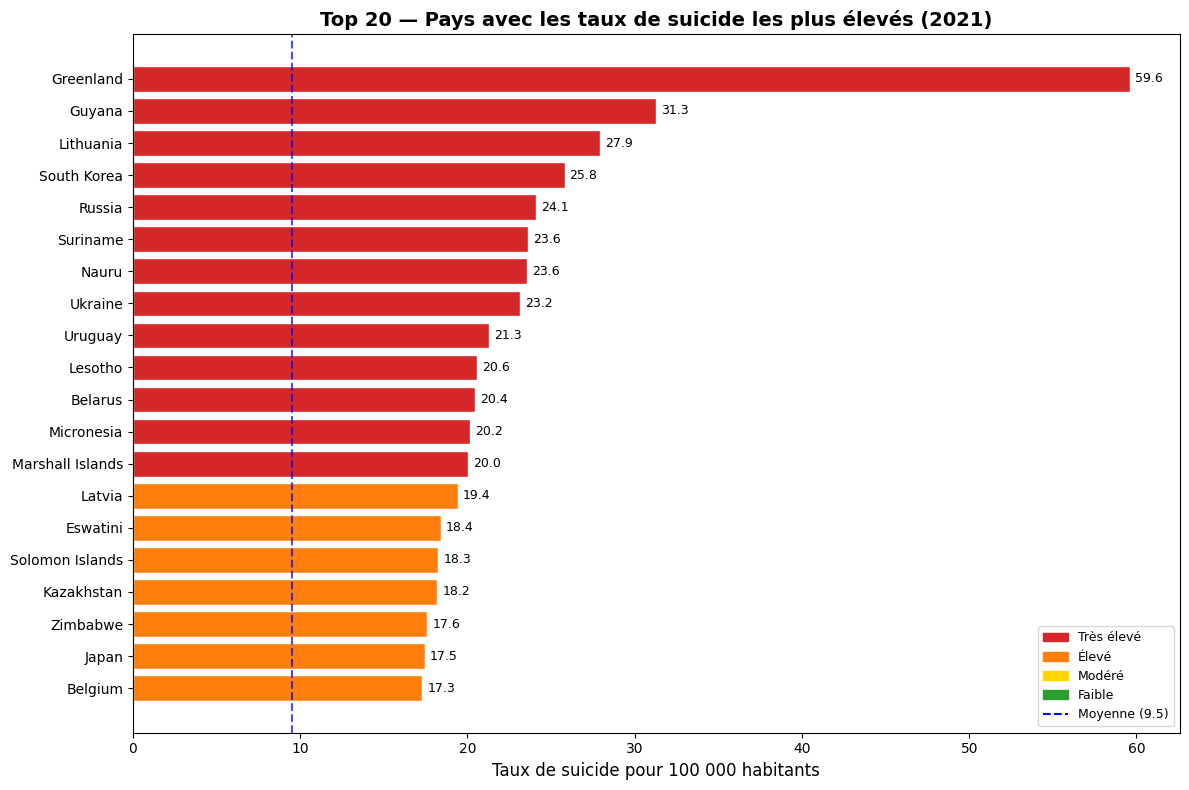

In [25]:
# GRAPHIQUE 1 — Top 20 pays (taux global 2021) - Barres horizontales
top20 = df_pd.nlargest(20, 'rate_2021')

colors = {
    'Très élevé': '#d62728',
    'Élevé': '#ff7f0e',
    'Modéré': '#ffd700',
    'Faible': '#2ca02c'
}

fig, ax = plt.subplots(figsize=(12, 8))
bar_colors = [colors.get(r, '#1f77b4') for r in top20['risk_level']]
bars = ax.barh(top20['country'], top20['rate_2021'], color=bar_colors, edgecolor='white')

for bar, val in zip(bars, top20['rate_2021']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}', va='center', fontsize=9)

ax.set_xlabel('Taux de suicide pour 100 000 habitants', fontsize=12)
ax.set_title('Top 20 — Pays avec les taux de suicide les plus élevés (2021)',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.axvline(x=df_pd['rate_2021'].mean(), color='blue', linestyle='--', alpha=0.7, label=f"Moyenne mondiale ({df_pd['rate_2021'].mean():.1f})")

legend_patches = [mpatches.Patch(color=v, label=k) for k, v in colors.items()]
ax.legend(handles=legend_patches + [plt.Line2D([0],[0],color='blue',linestyle='--',label=f'Moyenne ({df_pd["rate_2021"].mean():.1f})')],
          loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()

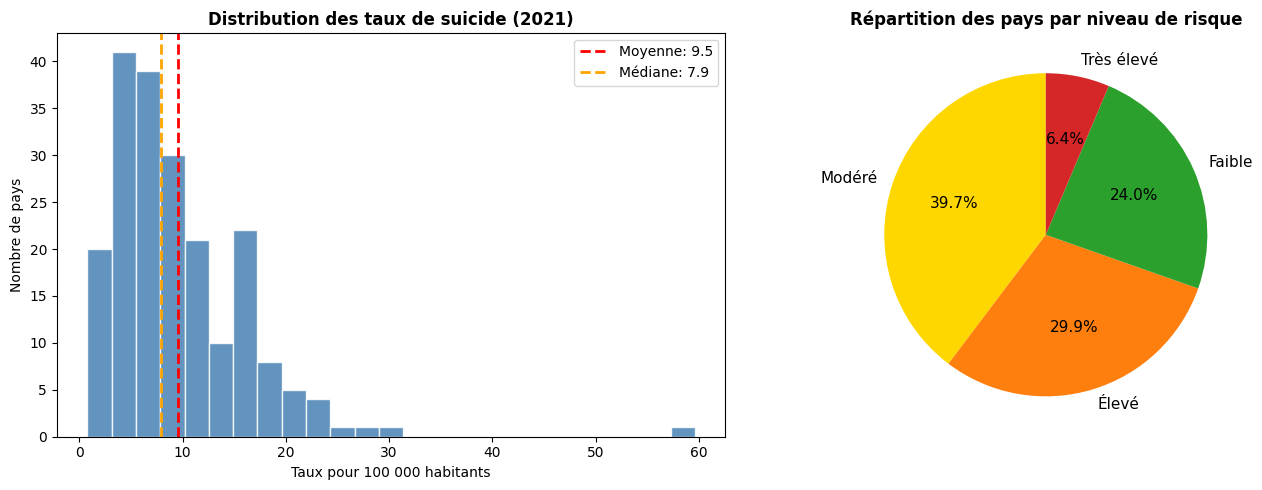

In [26]:
# GRAPHIQUE 2 — Histogramme de distribution des taux
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution globale
axes[0].hist(df_pd['rate_2021'], bins=25, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].axvline(df_pd['rate_2021'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df_pd["rate_2021"].mean():.1f}')
axes[0].axvline(df_pd['rate_2021'].median(), color='orange', linestyle='--', linewidth=2, label=f'Médiane: {df_pd["rate_2021"].median():.1f}')
axes[0].set_title('Distribution des taux de suicide (2021)', fontweight='bold')
axes[0].set_xlabel('Taux pour 100 000 habitants')
axes[0].set_ylabel('Nombre de pays')
axes[0].legend()

# Répartition par niveau de risque (camembert)
risk_counts = df_pd['risk_level'].value_counts()
pie_colors = [colors.get(k, 'gray') for k in risk_counts.index]
axes[1].pie(risk_counts.values, labels=risk_counts.index, colors=pie_colors,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Répartition des pays par niveau de risque', fontweight='bold')

plt.tight_layout()
plt.show()

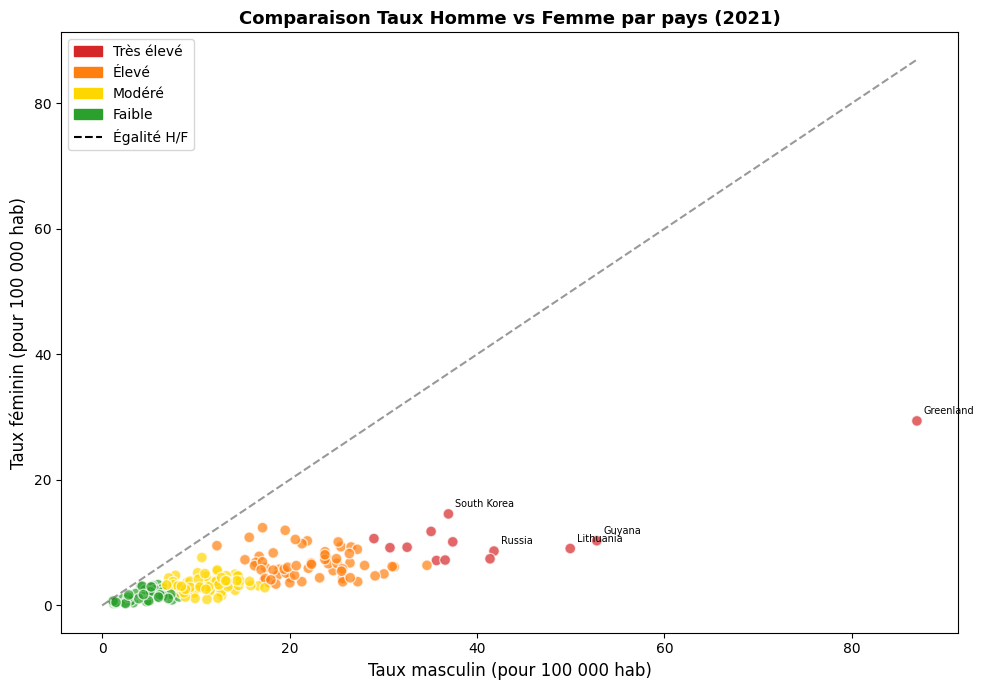

In [27]:
# GRAPHIQUE 3 — Taux Homme vs Femme (scatter plot)
fig, ax = plt.subplots(figsize=(10, 7))

scatter_colors = [colors.get(r, 'gray') for r in df_pd['risk_level']]
sc = ax.scatter(df_pd['male_2021'], df_pd['female_2021'],
                c=scatter_colors, alpha=0.7, s=60, edgecolors='white')

# Ligne y = x (égalité homme/femme)
max_val = max(df_pd['male_2021'].max(), df_pd['female_2021'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.4, label='Égalité H/F')

# Annoter quelques pays extrêmes
for _, row in df_pd.nlargest(5, 'rate_2021').iterrows():
    ax.annotate(row['country'], (row['male_2021'], row['female_2021']),
                textcoords="offset points", xytext=(5, 5), fontsize=7, color='black')

ax.set_xlabel('Taux masculin (pour 100 000 hab)', fontsize=12)
ax.set_ylabel('Taux féminin (pour 100 000 hab)', fontsize=12)
ax.set_title('Comparaison Taux Homme vs Femme par pays (2021)', fontweight='bold', fontsize=13)
legend_patches = [mpatches.Patch(color=v, label=k) for k, v in colors.items()]
ax.legend(handles=legend_patches + [plt.Line2D([0],[0],color='k',linestyle='--',label='Égalité H/F')])
plt.tight_layout()
plt.show()

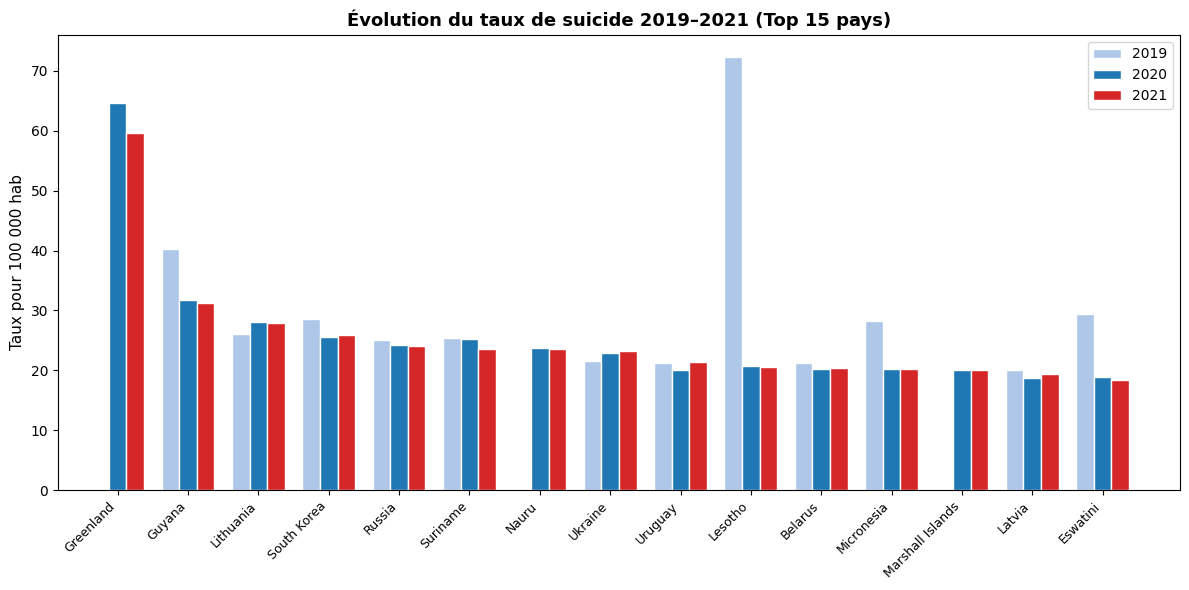

In [28]:
# GRAPHIQUE 4 — Évolution temporelle (2019 → 2021)
# Prendre les 15 pays avec les taux les plus élevés en 2021
top15_pd = df_pd.nlargest(15, 'rate_2021')

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(top15_pd))
width = 0.25

bars1 = ax.bar(x - width, top15_pd['rate_2019'], width, label='2019', color='#aec7e8', edgecolor='white')
bars2 = ax.bar(x,         top15_pd['rate_2020'], width, label='2020', color='#1f77b4', edgecolor='white')
bars3 = ax.bar(x + width, top15_pd['rate_2021'], width, label='2021', color='#d62728', edgecolor='white')

ax.set_xticks(x)
ax.set_xticklabels(top15_pd['country'], rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Taux pour 100 000 hab', fontsize=11)
ax.set_title('Évolution du taux de suicide 2019–2021 (Top 15 pays)', fontweight='bold', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

## Partie 7 — Machine Learning avec MLlib

On applique deux modèles ML :
1. **Clustering K-Means** : regrouper les pays en clusters selon leurs taux
2. **Régression Linéaire** : prédire le taux global à partir du taux masculin et féminin


### 7.1 — Clustering K-Means

K-Means regroupe les pays en **K clusters** basés sur leurs taux de suicide (homme, femme, global).

> Aucune variable cible — c'est de l'**apprentissage non supervisé**.


In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Préparer les features
feature_cols = ["rate_2021", "male_2021", "female_2021", "gender_gap_2021"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="skip")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

# Définir KMeans avec K=4 (correspondant à nos 4 niveaux de risque)
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)

# Pipeline
pipeline_kmeans = Pipeline(stages=[assembler, scaler, kmeans])
model_kmeans = pipeline_kmeans.fit(df_enriched)

# Prédictions
df_clustered = model_kmeans.transform(df_enriched)

print("Clustering KMeans terminé !")
df_clustered.select("country", "rate_2021", "risk_level", "cluster").show(15, truncate=False)

Clustering KMeans terminé !
+-----------+---------+----------+-------+
|country    |rate_2021|risk_level|cluster|
+-----------+---------+----------+-------+
|Chad       |5.43     |Modéré    |0      |
|Russia     |24.1     |Très élevé|1      |
|Paraguay   |5.8      |Modéré    |0      |
|Yemen      |3.56     |Faible    |0      |
|Senegal    |7.58     |Modéré    |3      |
|Sweden     |12.32    |Élevé     |3      |
|Tokelau    |15.83    |Élevé     |1      |
|Kiribati   |17.29    |Élevé     |1      |
|Guyana     |31.26    |Très élevé|1      |
|Philippines|3.77     |Faible    |0      |
|Eritrea    |9.66     |Modéré    |3      |
|Djibouti   |5.63     |Modéré    |0      |
|Tonga      |4.64     |Faible    |0      |
|Malaysia   |5.17     |Modéré    |0      |
|Singapore  |7.75     |Modéré    |3      |
+-----------+---------+----------+-------+
only showing top 15 rows


In [31]:
# Évaluer la qualité du clustering (WSSSE)
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
silhouette = evaluator.evaluate(df_clustered)
print(f"Score Silhouette : {silhouette:.4f}")
print("→ Score entre -1 et 1. Plus il est proche de 1, meilleur est le clustering.")

# Profil de chaque cluster
print("\nPROFIL DES CLUSTERS :")
df_clustered.groupBy("cluster").agg(
    F.count("*").alias("nb_pays"),
    F.round(F.avg("rate_2021"), 2).alias("taux_moyen"),
    F.round(F.avg("gender_gap_2021"), 2).alias("ecart_hf_moyen")
).orderBy("taux_moyen", ascending=False).show()

Score Silhouette : 0.5792
→ Score entre -1 et 1. Plus il est proche de 1, meilleur est le clustering.

PROFIL DES CLUSTERS :
+-------+-------+----------+--------------+
|cluster|nb_pays|taux_moyen|ecart_hf_moyen|
+-------+-------+----------+--------------+
|      2|      1|     59.62|         57.56|
|      1|     45|     18.12|         21.21|
|      3|     66|      9.96|         10.37|
|      0|     92|      4.46|          4.72|
+-------+-------+----------+--------------+



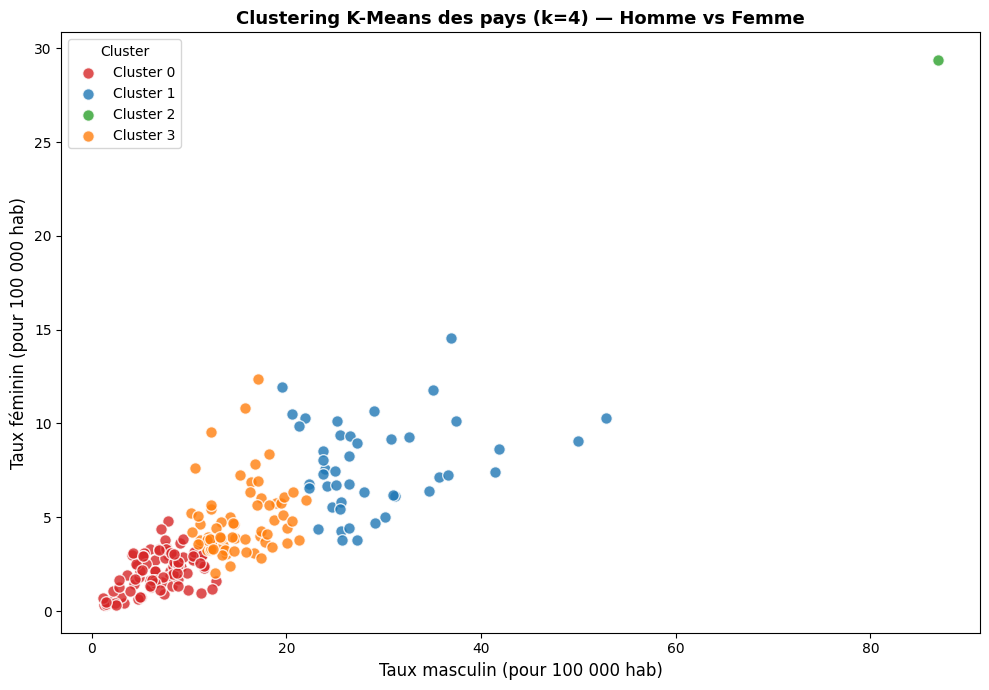

In [32]:
# Visualiser les clusters
df_clust_pd = df_clustered.select("country", "rate_2021", "male_2021",
                                    "female_2021", "cluster").toPandas()

fig, ax = plt.subplots(figsize=(10, 7))
cluster_colors = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e']

for cluster_id in sorted(df_clust_pd['cluster'].unique()):
    mask = df_clust_pd['cluster'] == cluster_id
    ax.scatter(df_clust_pd[mask]['male_2021'], df_clust_pd[mask]['female_2021'],
               c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}',
               alpha=0.8, s=70, edgecolors='white')

ax.set_xlabel('Taux masculin (pour 100 000 hab)', fontsize=12)
ax.set_ylabel('Taux féminin (pour 100 000 hab)', fontsize=12)
ax.set_title('Clustering K-Means des pays (k=4) — Homme vs Femme', fontweight='bold', fontsize=13)
ax.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 7.2 — Régression Linéaire : Prédire le taux global

On utilise une **régression linéaire** pour prédire le taux global (`rate_2021`) à partir des taux masculin et féminin.

> C'est de l'**apprentissage supervisé** : on connaît la variable cible.


In [33]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Préparer les données pour la régression
assembler_reg = VectorAssembler(
    inputCols=["male_2021", "female_2021", "gender_gap_2021"],
    outputCol="features",
    handleInvalid="skip"
)

df_ml = assembler_reg.transform(df_enriched).select("country", "features", F.col("rate_2021").alias("label"))

# Diviser en train (80%) / test (20%)
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)
print(f"Train : {train_df.count()} pays | Test : {test_df.count()} pays")

Train : 173 pays | Test : 31 pays


In [34]:
# Entraîner le modèle de régression
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_df)

print("Modèle entraîné !")
print(f"Intercept : {lr_model.intercept:.4f}")
print(f"Coefficients : male={lr_model.coefficients[0]:.4f}, "
      f"female={lr_model.coefficients[1]:.4f}, gap={lr_model.coefficients[2]:.4f}")

Modèle entraîné !
Intercept : -0.0083
Coefficients : male=0.2219, female=0.8251, gap=0.2535


In [35]:
# Évaluer le modèle sur le test set
predictions = lr_model.transform(test_df)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)

print("ÉVALUATION DU MODÈLE DE RÉGRESSION LINÉAIRE")
print("=" * 50)
print(f"  RMSE (erreur moyenne)  : {rmse:.4f}")
print(f"  R² (qualité du modèle) : {r2:.4f}")
print(f"\n→ R² proche de 1 = le modèle explique bien la variance des données.")

print("\nQuelques prédictions vs valeurs réelles :")
predictions.select("country",
                   F.round("label", 2).alias("taux_réel"),
                   F.round("prediction", 2).alias("taux_prédit")).show(10, truncate=False)

ÉVALUATION DU MODÈLE DE RÉGRESSION LINÉAIRE
  RMSE (erreur moyenne)  : 0.1996
  R² (qualité du modèle) : 0.9987

→ R² proche de 1 = le modèle explique bien la variance des données.

Quelques prédictions vs valeurs réelles :
+----------------------+---------+-----------+
|country               |taux_réel|taux_prédit|
+----------------------+---------+-----------+
|Algeria               |2.76     |2.79       |
|Antigua and Barbuda   |1.38     |1.35       |
|Armenia               |5.53     |5.6        |
|Bahrain               |4.28     |3.61       |
|Benin                 |5.32     |5.32       |
|Bosnia and Herzegovina|10.7     |10.72      |
|Burundi               |7.13     |7.08       |
|Chad                  |5.43     |5.45       |
|Czech Republic        |12.56    |12.51      |
|DR Congo              |8.12     |8.04       |
+----------------------+---------+-----------+
only showing top 10 rows


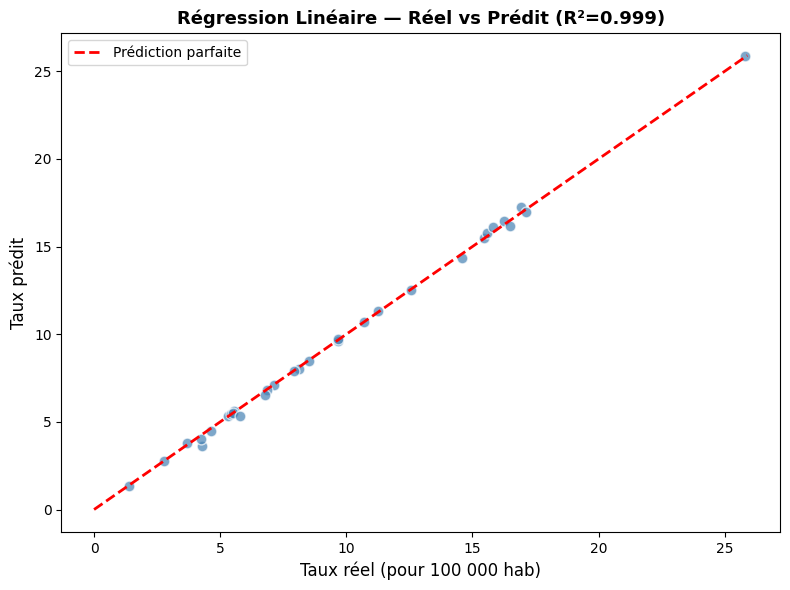

In [36]:
# Visualiser les prédictions vs réalité
pred_pd = predictions.select(
    F.col("label").alias("reel"),
    F.col("prediction").alias("predit")
).toPandas()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pred_pd['reel'], pred_pd['predit'], alpha=0.7, color='steelblue', edgecolors='white', s=60)

# Ligne parfaite
max_v = max(pred_pd['reel'].max(), pred_pd['predit'].max())
ax.plot([0, max_v], [0, max_v], 'r--', lw=2, label='Prédiction parfaite')

ax.set_xlabel('Taux réel (pour 100 000 hab)', fontsize=12)
ax.set_ylabel('Taux prédit', fontsize=12)
ax.set_title(f'Régression Linéaire — Réel vs Prédit (R²={r2:.3f})', fontweight='bold', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

### 7.3 — Classification : Prédire le niveau de risque

On utilise un **Random Forest Classifier** pour prédire si un pays est à risque élevé ou faible.


In [37]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Encoder la colonne catégorielle risk_level en entier
indexer = StringIndexer(inputCol="risk_level", outputCol="label_idx")

assembler_clf = VectorAssembler(
    inputCols=["rate_2019", "rate_2020", "male_2021", "female_2021", "gender_gap_2021"],
    outputCol="features",
    handleInvalid="skip"
)

rf = RandomForestClassifier(
    featuresCol="features", labelCol="label_idx",
    numTrees=50, maxDepth=5, seed=42
)

pipeline_rf = Pipeline(stages=[assembler_clf, indexer, rf])

# Split train/test
train_clf, test_clf = df_enriched.randomSplit([0.8, 0.2], seed=42)
model_rf = pipeline_rf.fit(train_clf)

print("Random Forest entraîné !")

Random Forest entraîné !


In [38]:
# Évaluer le Random Forest
preds_clf = model_rf.transform(test_clf)

eval_acc = MulticlassClassificationEvaluator(
    labelCol="label_idx", predictionCol="prediction", metricName="accuracy"
)
accuracy = eval_acc.evaluate(preds_clf)

print(f"Accuracy du Random Forest : {accuracy:.4f} ({accuracy*100:.1f}%)")

# Importance des features
rf_model = model_rf.stages[-1]
feature_names = ["rate_2019", "rate_2020", "male_2021", "female_2021", "gender_gap_2021"]
importances = list(zip(feature_names, rf_model.featureImportances.toArray()))
importances.sort(key=lambda x: x[1], reverse=True)

print("\nImportance des variables :")
for feat, imp in importances:
    bar = '█' * int(imp * 50)
    print(f"  {feat:<25} : {imp:.4f}  {bar}")

Accuracy du Random Forest : 1.0000 (100.0%)

Importance des variables :
  rate_2020                 : 0.6234  ███████████████████████████████
  male_2021                 : 0.2239  ███████████
  rate_2019                 : 0.0651  ███
  gender_gap_2021           : 0.0553  ██
  female_2021               : 0.0324  █


## Récapitulatif des Concepts Appris

| Concept | Explication | Exemple utilisé |
|---------|-------------|-----------------|
| `SparkContext` | Point d'entrée bas niveau | `sc = SparkContext.getOrCreate()` |
| `RDD` | Collection distribuée | `sc.textFile("suicide.csv")` |
| `map()` / `filter()` | Transformations RDD | Extraire taux, filtrer nulls |
| `reduceByKey()` | Agrégation MapReduce | Compter pays par niveau de risque |
| `stats()` | Statistiques RDD | Min, max, moyenne, stdev |
| `SparkSession` | Point d'entrée moderne | `SparkSession.builder...` |
| `DataFrame` | Table structurée et typée | `spark.read.csv(...)` |
| `withColumn()` | Créer/modifier une colonne | gender_gap, risk_level |
| `spark.sql()` | Requêtes SQL sur DataFrames | TOP 15, GROUP BY |
| `VectorAssembler` | Préparer les features ML | Assembler colonnes numériques |
| `KMeans` | Clustering non supervisé | Regrouper pays par profil |
| `LinearRegression` | Régression supervisée | Prédire le taux global |
| `RandomForest` | Classification supervisée | Prédire le niveau de risque |
| **Lazy evaluation** | Transformations = plan, actions = exécution | Tout le pipeline |

### Points Clés à Retenir :
- **RDD** → bas niveau, flexible, mais verbeux
- **DataFrame** → haut niveau, expressif, optimisé par le moteur Catalyst
- **MLlib Pipeline** : Assembler → Scaler → Modèle → Évaluation
- **Pattern MapReduce** : `map → filter → reduceByKey` = base du Big Data
